# Задание
Преподаватель: Даниил Корбут, Наталья Баданина, Александр Миленькин

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [143]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
%matplotlib inline

In [144]:
sales_of_company_x = pd.read_csv("data/Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("data/Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("data/Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("data/Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("data/Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("data/Series/daily-total-female-births-in-cal.csv")

In [145]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

In [146]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [147]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

### 1. Daily total female births in California

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


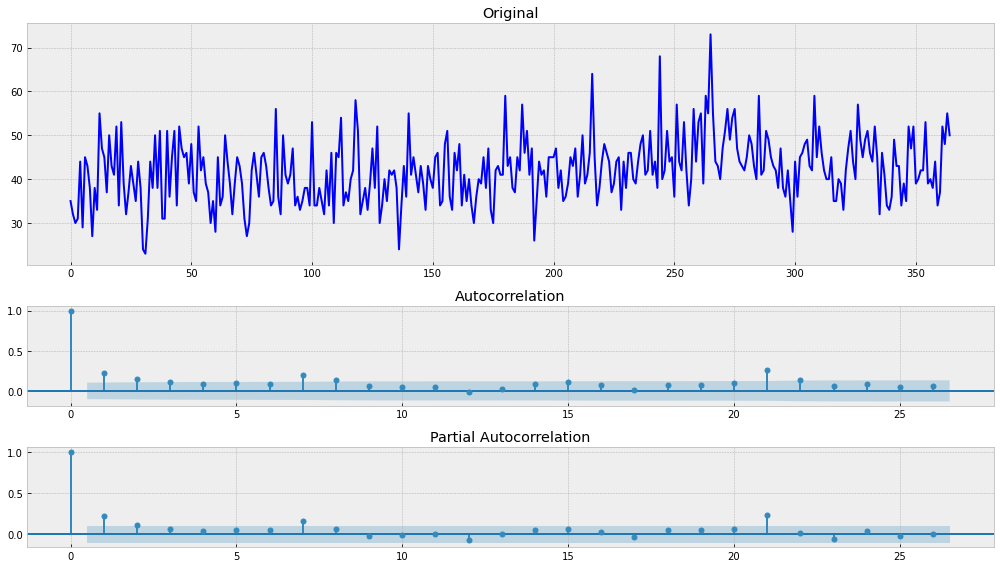

In [148]:
tsplot(all_series["Daily total female births in California"])

Этот ряд является стационарным.

In [149]:
series = female_births['Count']

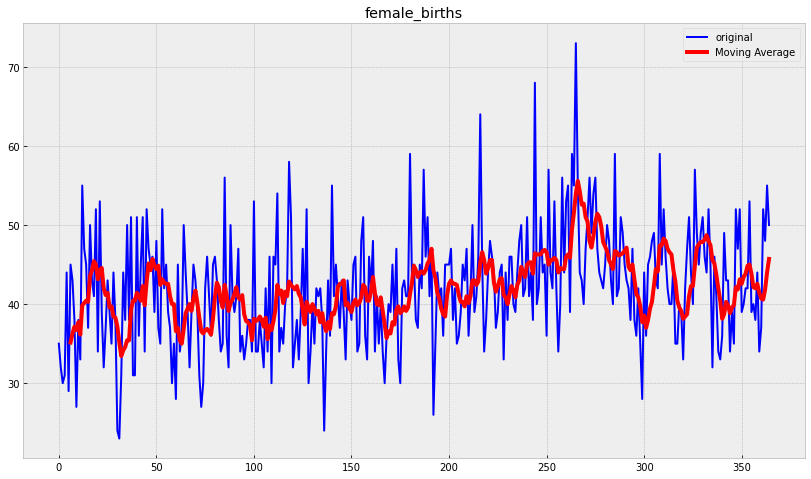

In [150]:
# MA - скользящее среднее
ma=series.rolling(7).mean()

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('female_births')
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='4', label='Moving Average')
    plt.legend()

скользящее среднее плохо потворяет ряд

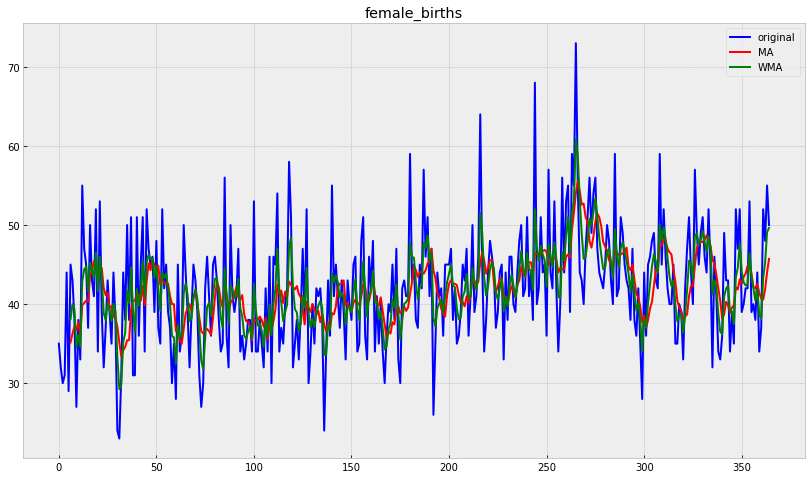

In [151]:
# WMA - взвешенное скользящее среднее

weights=np.array([1,1,2,3,5,8,13])
wma = series.rolling(7).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('female_births')
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

взвешенное скользящее среднее плохо повторяет ряд

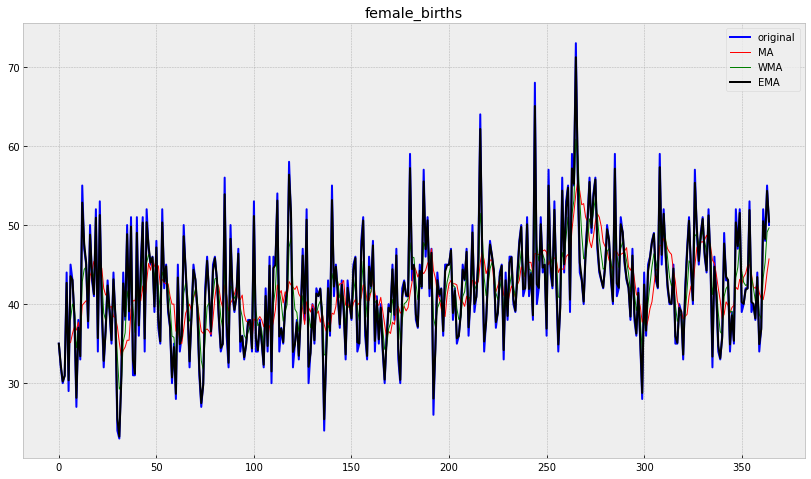

In [152]:
# EMA - экспоненциальное сглаживание
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

ema = exponential_moving_average(series, 0.9)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('female_births')    
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='1', label='MA')
    plt.plot(wma, color='green', linewidth='1', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()


Видим, что с коэффициентом = 0.9 экспоненциальное сглаживание очень хорошо описывает ряд.


У ряда нет сезонности и тренда, поэтому применять DEMA и TEMA не будем.

### Подберем параметры модели.

In [154]:
train_size=round(len(series)*.7)
test_size=round(len(series)*.25)
train, val = series[:train_size], series[train_size:]

def mse_cross_val(X,):
    alpha = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    k=0
    for train_split, test_split in split.split(series):
        
        result = exponential_moving_average(train_split, alpha)
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)
        k+=1
        
    return np.mean(np.array(errors))

opt = minimize(mse_cross_val, x0=np.array([0.3]), method="L-BFGS-B", bounds = ((0, 1),))

alpha_opt = opt.x
print(opt)

      fun: 8281.0
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-182.00025715])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([1.])


Получаем, что оптимальное значение параметра alpha = 1.  
Проверим результат на тестовых данных:

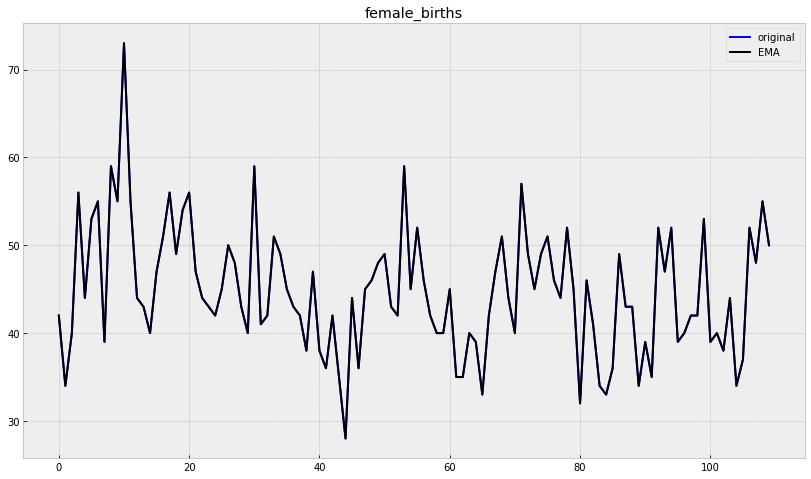

In [155]:
val = val.reset_index()
val.drop(columns = 'index')
val = val['Count']
ema = exponential_moving_average(val, 1.0)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('female_births')    
    plt.plot(val, color='blue',label='original')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

In [158]:
# Измерим качество модели
r2_score(y_pred=ema, y_true=val)

1.0

### 2. International airline passengers: monthly totals in thousands

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


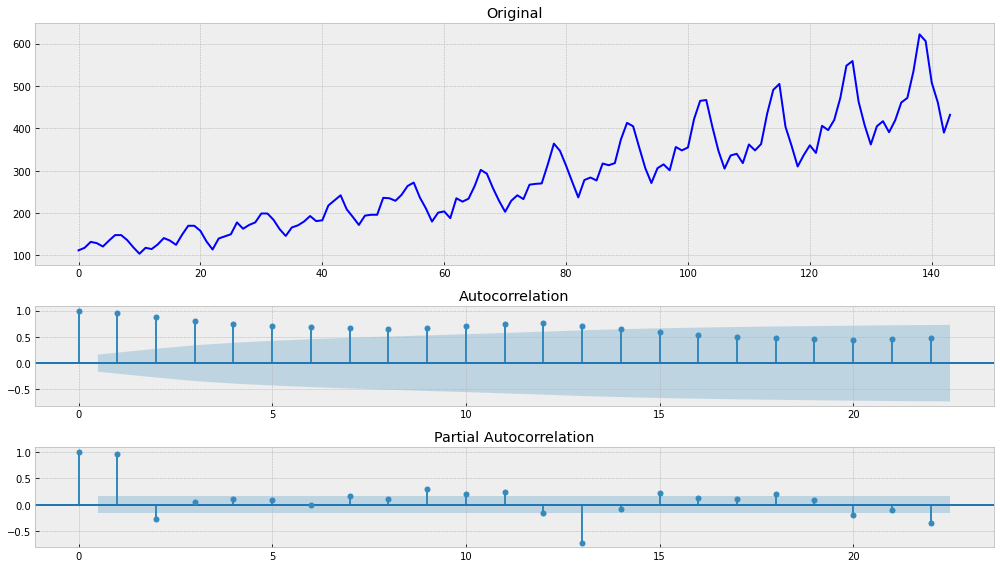

In [124]:
tsplot(airlines_passengers["Count"])

Судя по метрикам p-value и Test Statistic, ряд не стационарен. Также наблюдаем тренд и сезонность.

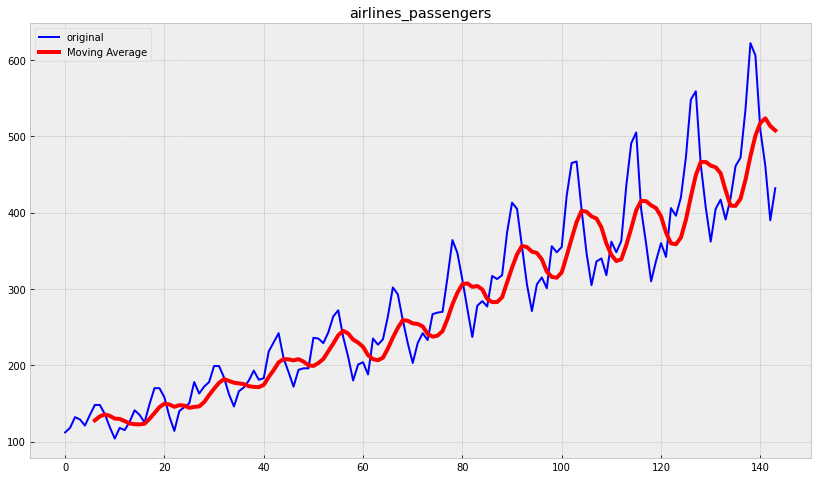

In [125]:
# MA - скользящее среднее
ma=airlines_passengers.rolling(7).mean()
series = airlines_passengers["Count"]

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Скользящее среднее плохо приближает ряд.

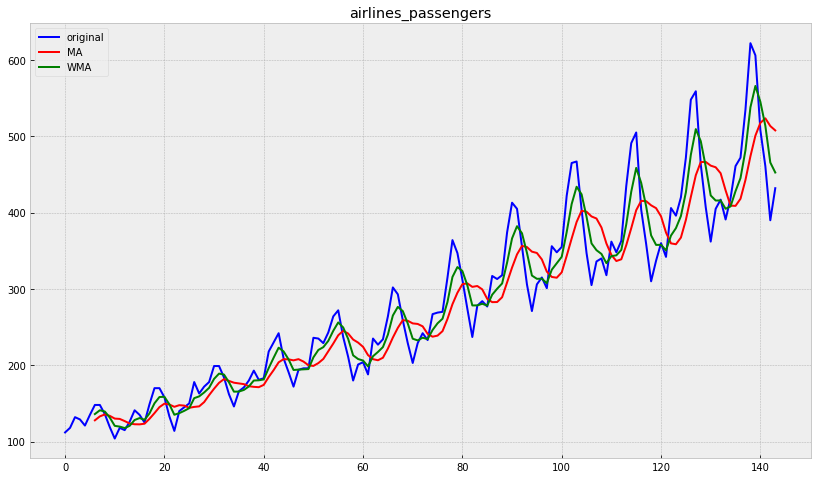

In [126]:
# WMA - взвешенное скользящее среднее

weights=np.array([1,1,2,3,5,8,13])
wma = airlines_passengers.rolling(7).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
series = airlines_passengers["Count"]

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

Взвешенное скользящее среднее все еще плохо приближает ряд

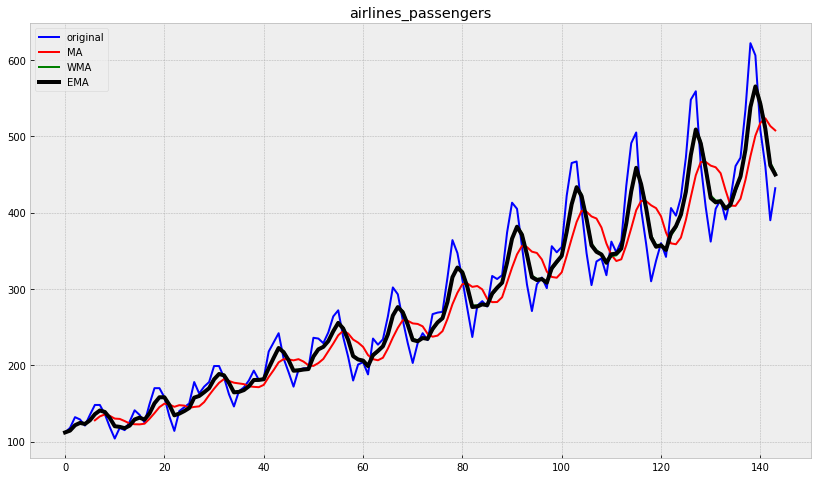

In [127]:
# EMA - экспоненциальное сглаживание
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

series = airlines_passengers["Count"]
ema = exponential_moving_average(series, 0.4)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')    
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

Экспоненциальное сглаживание недостаточно хорошо приближает ряд.

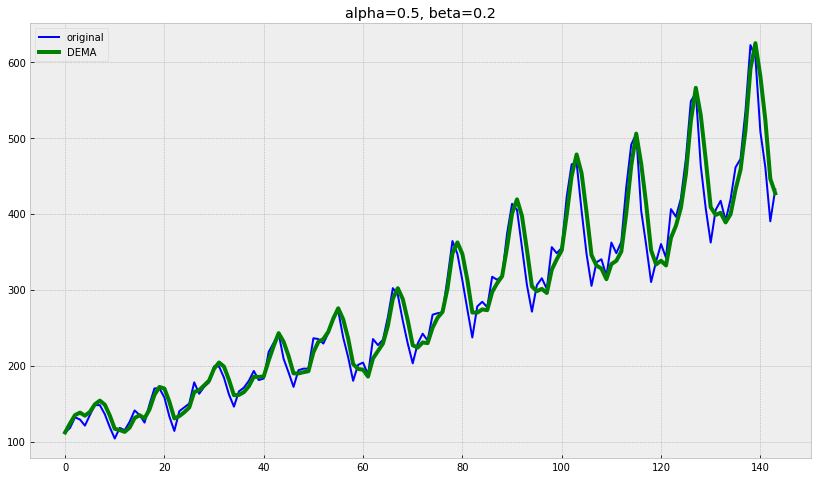

In [128]:
# DEMA - двойное экспоненциальное сглаживание

def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

alpha=0.5
beta=0.2
series = airlines_passengers["Count"]
dema = double_ema(series, alpha, beta)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')    
    plt.plot(series, color='blue',label='original')
    plt.plot(dema, color='green', linewidth='4', label='DEMA')
    plt.title("alpha={}, beta={}".format(alpha, beta))
    plt.legend()

Видим, что коэффициенты 0.5 и 0.2 дают довольно неплохой результат.

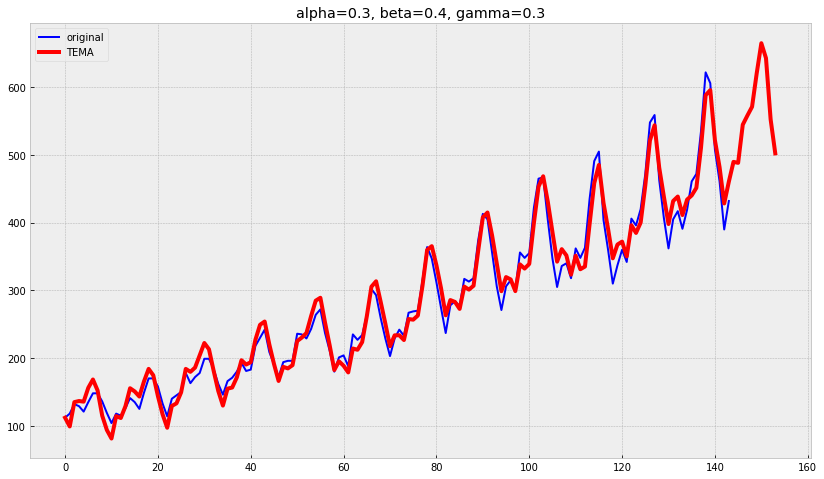

In [129]:
# tema - Хольт-Винтерс (учтем сезонность)

def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = sum([float(series[i + slen] - series[i]) / slen]) / slen
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

alpha=0.3
beta=0.4
gamma=0.3
n_periods2_pred=10

series = airlines_passengers["Count"]

tema = triple_exponential_smoothing(series, 12, alpha, beta, gamma, n_periods2_pred)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')      
    plt.plot(series, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()


Видим, что TEMA позволяет довольно хорошо описать ряд.

Подберем параметры модели.

In [159]:
series = airlines_passengers["Count"]
train_size=round(len(series)*.7)
test_size=round(len(series)*.25)
train, val = series[:train_size], series[train_size:]

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(mean_monthly_temp):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4.1862774161223864e-08
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.29204423e-06, -7.66978182e-06,  1.56716284e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 284
      nit: 55
     njev: 71
   status: 0
  success: True
        x: array([0.0587345 , 0.17765063, 0.89171637])


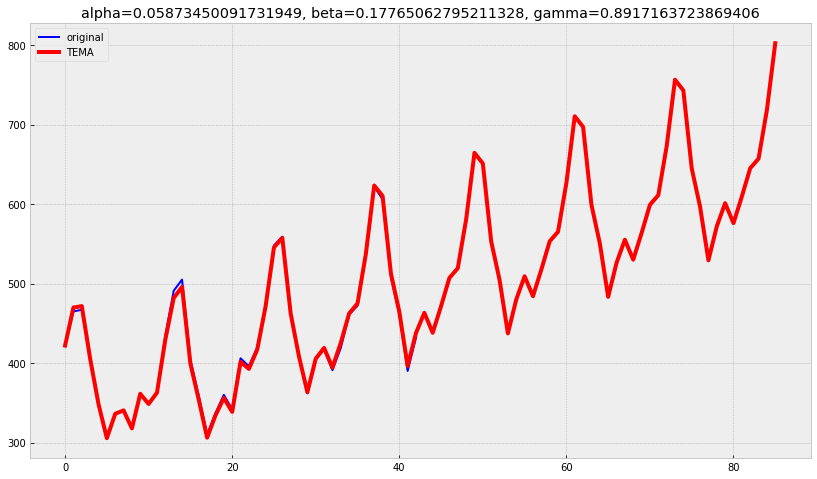

In [161]:
val = val.reset_index()
val.drop(columns = 'index')
val = val['Count']
tema = triple_exponential_smoothing(val, 12, alpha_opt, beta_opt, gamma_opt, len(val))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')      
    plt.plot(val, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

In [165]:
# Измерим качество модели
r2_score(y_pred=tema[:len(val)], y_true=val)

0.9975948737083034

Модель Холта-Винтерса позволяет хорошо предсказывать ряд, учитывая, что у него наблюдаются сезонность и тренд.